In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE


In [2]:
# Load and inspect the data
df = pd.read_csv('E:/Capstone_ICR_Project/Dataset/State_wise_Data_final/Illinois_10_years_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2969937 entries, 0 to 2969936
Data columns (total 31 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   Year                              int64  
 1   Quarter                           int64  
 2   Month                             int64  
 3   Day_of_Month                      float64
 4   Day_of_Week                       float64
 5   Operating_Carrier_Code            object 
 6   Tail_Number                       object 
 7   Origin_Airport_ID                 float64
 8   Origin_Airport_Code               object 
 9   Origin_State_Name                 object 
 10  Destination_Airport_Code          object 
 11  Destination_State_Name            object 
 12  Scheduled_Departure_Time          float64
 13  Departure_Delay_Minutes           float64
 14  Taxi_Out_Time_Minutes             float64
 15  Flight_Distance_Miles             float64
 16  Departure_Datetime                ob

In [3]:
# Drop unnecessary columns
df = df.drop(['Origin_State_Name', 'Departure_Datetime', 'Departure_Delay_Minutes','Taxi_Out_Time_Minutes'], axis=1)

In [4]:
# Convert integer features to int32
int_columns = [
    'Year', 
    'Quarter', 
    'Month', 
    'Day_of_Month', 
    'Day_of_Week', 
    'Scheduled_Departure_Time', 
    'Scheduled_Departure_Time_Minutes',
    'Target'
]

for col in int_columns:
    df[col] = df[col].astype(np.int32)

In [5]:
# Convert continuous numeric features to float32
float_columns = [
    
    'Flight_Distance_Miles',
    'Air_Temperature_Fahrenheit',
    'Dew_Point_Temperature_Fahrenheit',
    'Relative_Humidity_Percent',
    'Wind_Direction_Degrees',
    'Wind_Speed_Knots',
    'Hourly_Precipitation_Inches',
    'Pressure_Altimeter_Inches',
    'Sea_Level_Pressure_Millibar',
    'Visibility_Miles',
    'Sky_Level_1_Altitude_Feet',
    'Apparent_Temperature_Fahrenheit',
]

for col in float_columns:
    df[col] = df[col].astype(np.float32)

In [6]:
# Convert categorical features to 'category' dtype
categorical_columns = [
    'Operating_Carrier_Code',
    'Tail_Number',
    'Origin_Airport_ID',
    'Origin_Airport_Code',
    'Destination_Airport_Code',
    'Destination_State_Name',
    'Sky_Cover_Level_1'
]

for col in categorical_columns:
    df[col] = df[col].astype('category')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2969937 entries, 0 to 2969936
Data columns (total 27 columns):
 #   Column                            Dtype   
---  ------                            -----   
 0   Year                              int32   
 1   Quarter                           int32   
 2   Month                             int32   
 3   Day_of_Month                      int32   
 4   Day_of_Week                       int32   
 5   Operating_Carrier_Code            category
 6   Tail_Number                       category
 7   Origin_Airport_ID                 category
 8   Origin_Airport_Code               category
 9   Destination_Airport_Code          category
 10  Destination_State_Name            category
 11  Scheduled_Departure_Time          int32   
 12  Flight_Distance_Miles             float32 
 13  Scheduled_Departure_Time_Minutes  int32   
 14  Air_Temperature_Fahrenheit        float32 
 15  Dew_Point_Temperature_Fahrenheit  float32 
 16  Relative_Humidity_

In [8]:
# Filter data for January and reset the Year type
df1 = df[df['Month'] == 1]
df1['Year'] = df1['Year'].astype(int)

C:\Users\admin\AppData\Local\Temp\ipykernel_13764\379487763.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Year'] = df1['Year'].astype(int)


In [9]:
# Define years for train, validation, and test sets
train_years = [2014, 2015, 2016, 2017, 2018, 2019]
val_years = [2020, 2021, 2022]
test_years = [2023, 2024]

In [10]:
# Split data into train, validation, and test sets
train_df = df1[df1['Year'].isin(train_years)].reset_index(drop=True)
val_df = df1[df1['Year'].isin(val_years)].reset_index(drop=True)
test_df = df1[df1['Year'].isin(test_years)].reset_index(drop=True)

## Flights and Wether Data

In [11]:
# Separate features and target
X_train = train_df.drop('Target', axis=1)
y_train = train_df['Target']
X_val = val_df.drop('Target', axis=1)
y_val = val_df['Target']
X_test = test_df.drop('Target', axis=1)
y_test = test_df['Target']

In [12]:
X_train.head()

,Year,Quarter,Month,Day_of_Month,Day_of_Week,Operating_Carrier_Code,Tail_Number,Origin_Airport_ID,Origin_Airport_Code,Destination_Airport_Code,...,Relative_Humidity_Percent,Wind_Direction_Degrees,Wind_Speed_Knots,Hourly_Precipitation_Inches,Pressure_Altimeter_Inches,Sea_Level_Pressure_Millibar,Visibility_Miles,Sky_Cover_Level_1,Sky_Level_1_Altitude_Feet,Apparent_Temperature_Fahrenheit
0,2014,1,1,1,3,AA,N363AA,13930.0,ORD,MIA,...,77.449997,60.0,14.0,0.020000,30.0,1025.099976,0.625,VV,1200.0,7.26
1,2014,1,1,1,3,AA,N372AA,13930.0,ORD,HNL,...,79.980003,350.0,7.0,0.000000,30.0,1025.099976,7.750,OVC,1300.0,3.17
2,2014,1,1,1,3,AA,N3AFAA,13930.0,ORD,BOS,...,77.449997,70.0,12.0,0.026667,30.0,1025.699951,0.750,BKN,1300.0,8.03
3,2014,1,1,1,3,AA,N3AHAA,13930.0,ORD,FLL,...,77.449997,50.0,11.0,0.027500,30.0,1024.099976,0.750,VV,1400.0,8.45
4,2014,1,1,1,3,AA,N3ANAA,13930.0,ORD,MIA,...,79.830002,270.0,8.0,0.001250,30.0,1025.500000,6.000,OVC,1200.0,0.34


In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158523 entries, 0 to 158522
Data columns (total 26 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   Year                              158523 non-null  int32   
 1   Quarter                           158523 non-null  int32   
 2   Month                             158523 non-null  int32   
 3   Day_of_Month                      158523 non-null  int32   
 4   Day_of_Week                       158523 non-null  int32   
 5   Operating_Carrier_Code            158523 non-null  category
 6   Tail_Number                       158523 non-null  category
 7   Origin_Airport_ID                 158523 non-null  category
 8   Origin_Airport_Code               158523 non-null  category
 9   Destination_Airport_Code          158523 non-null  category
 10  Destination_State_Name            158523 non-null  category
 11  Scheduled_Departure_Time          15852

In [14]:
# Ensure consistent encoding across all sets using pd.Categorical
for col in X_train.select_dtypes(include=['category']).columns:
    X_train[col] = pd.Categorical(X_train[col])
    X_val[col] = pd.Categorical(X_val[col], categories=X_train[col].cat.categories)
    X_test[col] = pd.Categorical(X_test[col], categories=X_train[col].cat.categories)

# Convert categorical columns to integer codes
X_train = X_train.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
X_val = X_val.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
X_test = X_test.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)

In [15]:
# Apply SMOTE to the training data only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [16]:
model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.05,  
    depth=10,             
    l2_leaf_reg=5,       
    eval_metric='AUC',   
    class_weights=[1, 2],  
    random_seed=42,
    use_best_model=True,
    early_stopping_rounds=100
)


In [17]:
train_pool = Pool(data=X_train_smote, label=y_train_smote)
val_pool = Pool(data=X_val, label=y_val)
test_pool = Pool(data=X_test, label=y_test)

model.fit(train_pool, eval_set=val_pool, verbose=100)

# Display the best iteration results
# print(f"Best Validation F1 Score: {model.best_score_['validation']['F1']}")
# print(f"Best Iteration: {model.best_iteration_}")

0:	test: 0.5746872	best: 0.5746872 (0)	total: 727ms	remaining: 24m 12s
100:	test: 0.6418296	best: 0.6423364 (52)	total: 24s	remaining: 7m 31s
200:	test: 0.6447682	best: 0.6463640 (154)	total: 46.3s	remaining: 6m 54s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6463639663
bestIteration = 154

Shrink model to first 155 iterations.


In [18]:
y_train_pred = model.predict(train_pool)
train_accuracy = accuracy_score(y_train_smote, y_train_pred)
train_conf_matrix = confusion_matrix(y_train_smote, y_train_pred)

print("Training Results:")
print(f"Accuracy: {train_accuracy:.2f}%")
print("Confusion Matrix:")
print(train_conf_matrix)
print("Classification Report:")
print(classification_report(y_train_smote, y_train_pred))

Training Results:
Accuracy: 0.80%
Confusion Matrix:
[[ 82839  32391]
 [ 13941 101289]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.72      0.78    115230
           1       0.76      0.88      0.81    115230

    accuracy                           0.80    230460
   macro avg       0.81      0.80      0.80    230460
weighted avg       0.81      0.80      0.80    230460



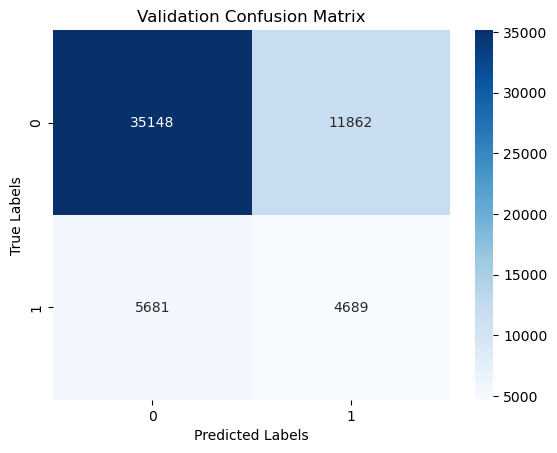

Validation Results:
Accuracy: 69.43%
Precision: 28.33%
Recall (TPR): 45.22%
F1 Score: 0.35


In [19]:
# Validation Confusion Matrix with Seaborn
y_val_pred = model.predict(val_pool)
val_conf_matrix = confusion_matrix(y_val, y_val_pred)
sns.heatmap(val_conf_matrix, cmap="Blues", annot=True, fmt='d')
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Calculate validation metrics
tn, fp, fn, tp = val_conf_matrix.ravel()
val_accuracy = ((tp + tn) / (tp + tn + fp + fn)) * 100
val_precision = (tp / (tp + fp)) * 100 if (tp + fp) != 0 else 0
val_recall = (tp / (tp + fn)) * 100 if (tp + fn) != 0 else 0
val_fpr = (fp / (fp + tn)) * 100 if (fp + tn) != 0 else 0
val_specificity = (tn / (tn + fp)) * 100 if (tn + fp) != 0 else 0
val_f1_score = (2 * (val_precision * val_recall) / (val_precision + val_recall)) * 0.01 if (val_precision + val_recall) != 0 else 0

# Display validation results
print("Validation Results:")
print(f"Accuracy: {val_accuracy:.2f}%")
print(f"Precision: {val_precision:.2f}%")
print(f"Recall (TPR): {val_recall:.2f}%")
# print(f"False Positive Rate (FPR): {val_fpr:.2f}%")
# print(f"Specificity (TNR): {val_specificity:.2f}%")
print(f"F1 Score: {val_f1_score:.2f}")

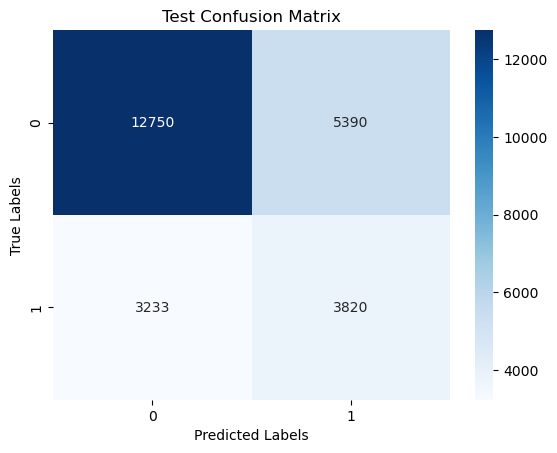

Test Results:
Accuracy: 65.77%
Precision: 41.48%
Recall (TPR): 54.16%
F1 Score: 0.47


In [20]:
# Test Confusion Matrix with Seaborn
y_test_pred = model.predict(test_pool)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(test_conf_matrix, cmap="Blues", annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Calculate test metrics
tn, fp, fn, tp = test_conf_matrix.ravel()
test_accuracy = ((tp + tn) / (tp + tn + fp + fn)) * 100
test_precision = (tp / (tp + fp)) * 100 if (tp + fp) != 0 else 0
test_recall = (tp / (tp + fn)) * 100 if (tp + fn) != 0 else 0
test_fpr = (fp / (fp + tn)) * 100 if (fp + tn) != 0 else 0
test_specificity = (tn / (tn + fp)) * 100 if (tn + fp) != 0 else 0
test_f1_score = (2 * (test_precision * test_recall) / (test_precision + test_recall)) * 0.01 if (test_precision + test_recall) != 0 else 0

# Display test results
print("Test Results:")
print(f"Accuracy: {test_accuracy:.2f}%")
print(f"Precision: {test_precision:.2f}%")
print(f"Recall (TPR): {test_recall:.2f}%")
# print(f"False Positive Rate (FPR): {test_fpr:.2f}%")
# print(f"Specificity (TNR): {test_specificity:.2f}%")
print(f"F1 Score: {test_f1_score:.2f}")

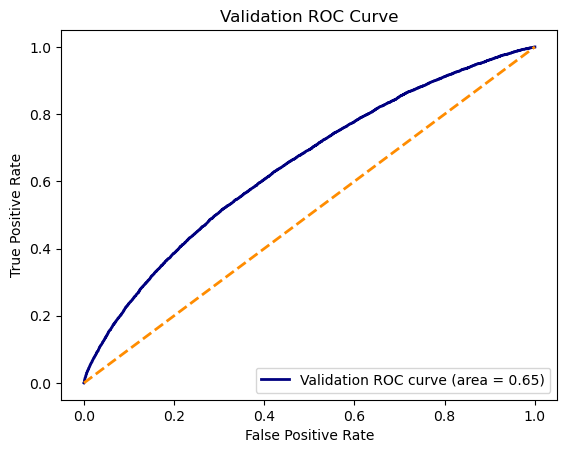

In [21]:
y_val_pred_proba = model.predict_proba(val_pool)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='navy', lw=2, label=f'Validation ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curve')
plt.legend(loc="lower right")
plt.show()

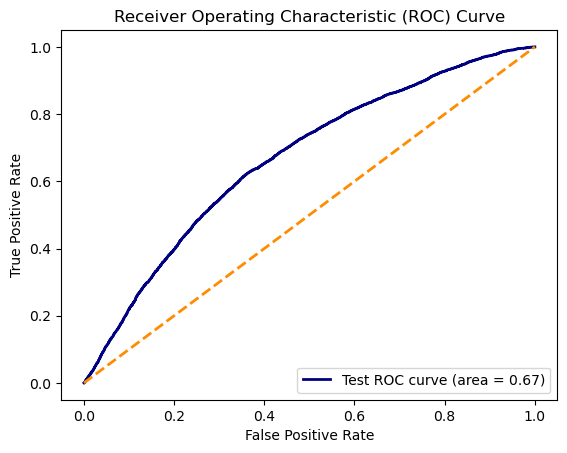

In [22]:
y_test_pred_proba = model.predict_proba(test_pool)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='navy', lw=2, label=f'Test ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

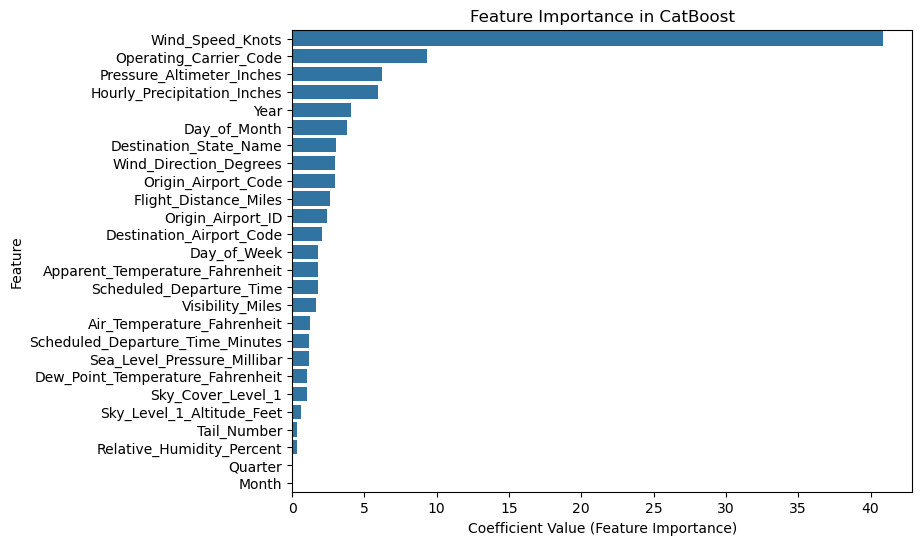

In [23]:
feature_importances = model.get_feature_importance()
feature_names = model.feature_names_

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6)) 
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, color='#1f77b4')  # Use the specific color
plt.title('Feature Importance in CatBoost')
plt.xlabel('Coefficient Value (Feature Importance)')
plt.ylabel('Feature')

plt.savefig('feature_importance_plot_catboost.png', dpi=300, bbox_inches='tight')
plt.show()

# Flights Data only

In [24]:
flights_columns = [
    "Quarter", "Month", "Day_of_Month", "Day_of_Week", "Operating_Carrier_Code", "Tail_Number",
    "Origin_Airport_ID", "Origin_Airport_Code", "Destination_Airport_Code",
    "Destination_State_Name", "Scheduled_Departure_Time", 
    "Flight_Distance_Miles", "Scheduled_Departure_Time_Minutes"
]


In [25]:
X_train = train_df[flights_columns]
y_train = train_df['Target']
X_val = val_df[flights_columns]
y_val = val_df['Target']
X_test = test_df[flights_columns]
y_test = test_df['Target']

In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158523 entries, 0 to 158522
Data columns (total 13 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   Quarter                           158523 non-null  int32   
 1   Month                             158523 non-null  int32   
 2   Day_of_Month                      158523 non-null  int32   
 3   Day_of_Week                       158523 non-null  int32   
 4   Operating_Carrier_Code            158523 non-null  category
 5   Tail_Number                       158523 non-null  category
 6   Origin_Airport_ID                 158523 non-null  category
 7   Origin_Airport_Code               158523 non-null  category
 8   Destination_Airport_Code          158523 non-null  category
 9   Destination_State_Name            158523 non-null  category
 10  Scheduled_Departure_Time          158523 non-null  int32   
 11  Flight_Distance_Miles             15852

In [27]:
X_train.head()

,Quarter,Month,Day_of_Month,Day_of_Week,Operating_Carrier_Code,Tail_Number,Origin_Airport_ID,Origin_Airport_Code,Destination_Airport_Code,Destination_State_Name,Scheduled_Departure_Time,Flight_Distance_Miles,Scheduled_Departure_Time_Minutes
0,1,1,1,3,AA,N363AA,13930.0,ORD,MIA,Florida,1715,1197.0,1035
1,1,1,1,3,AA,N372AA,13930.0,ORD,HNL,Hawaii,1100,4243.0,660
2,1,1,1,3,AA,N3AFAA,13930.0,ORD,BOS,Massachusetts,1520,867.0,920
3,1,1,1,3,AA,N3AHAA,13930.0,ORD,FLL,Florida,1900,1182.0,1140
4,1,1,1,3,AA,N3ANAA,13930.0,ORD,MIA,Florida,905,1197.0,545


In [28]:
for col in X_train.select_dtypes(include=['category']).columns:
    X_train[col] = pd.Categorical(X_train[col])
    X_val[col] = pd.Categorical(X_val[col], categories=X_train[col].cat.categories)
    X_test[col] = pd.Categorical(X_test[col], categories=X_train[col].cat.categories)

X_train = X_train.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
X_val = X_val.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
X_test = X_test.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)

C:\Users\admin\AppData\Local\Temp\ipykernel_13764\1344831284.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = pd.Categorical(X_train[col])
C:\Users\admin\AppData\Local\Temp\ipykernel_13764\1344831284.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[col] = pd.Categorical(X_val[col], categories=X_train[col].cat.categories)
C:\Users\admin\AppData\Local\Temp\ipykernel_13764\1344831284.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [29]:
# Apply SMOTE to the training data only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [30]:
model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.05,  
    depth=10,             
    l2_leaf_reg=5,       
    eval_metric='AUC',   
    class_weights=[1, 2],  
    random_seed=42,
    use_best_model=True,
    early_stopping_rounds=100
)


In [31]:
train_pool = Pool(data=X_train_smote, label=y_train_smote)
val_pool = Pool(data=X_val, label=y_val)
test_pool = Pool(data=X_test, label=y_test)

model.fit(train_pool, eval_set=val_pool, verbose=100)


0:	test: 0.5121496	best: 0.5121496 (0)	total: 141ms	remaining: 4m 41s
100:	test: 0.5153659	best: 0.5188661 (13)	total: 17.1s	remaining: 5m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5188661402
bestIteration = 13

Shrink model to first 14 iterations.


In [32]:
y_train_pred = model.predict(train_pool)
train_accuracy = accuracy_score(y_train_smote, y_train_pred)
train_conf_matrix = confusion_matrix(y_train_smote, y_train_pred)

print("Training Results:")
print(f"Accuracy: {train_accuracy:.2f}%")
print("Confusion Matrix:")
print(train_conf_matrix)
print("Classification Report:")
print(classification_report(y_train_smote, y_train_pred))

Training Results:
Accuracy: 0.61%
Confusion Matrix:
[[ 34330  80900]
 [  8698 106532]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.30      0.43    115230
           1       0.57      0.92      0.70    115230

    accuracy                           0.61    230460
   macro avg       0.68      0.61      0.57    230460
weighted avg       0.68      0.61      0.57    230460



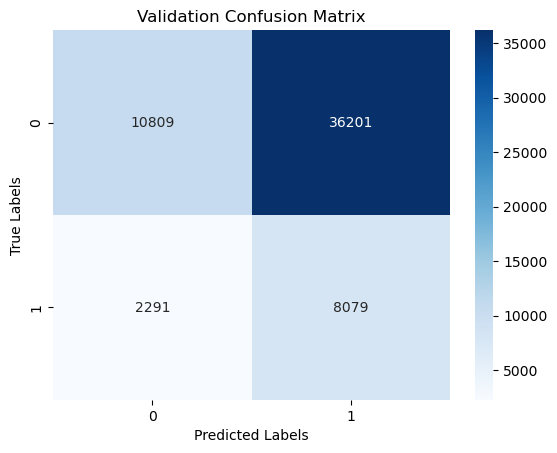

Validation Results:
Accuracy: 32.92%
Precision: 18.25%
Recall (TPR): 77.91%
F1 Score: 0.30


In [33]:
y_val_pred = model.predict(val_pool)
val_conf_matrix = confusion_matrix(y_val, y_val_pred)
sns.heatmap(val_conf_matrix, cmap="Blues", annot=True, fmt='d')
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Calculate validation metrics
tn, fp, fn, tp = val_conf_matrix.ravel()
val_accuracy = ((tp + tn) / (tp + tn + fp + fn)) * 100
val_precision = (tp / (tp + fp)) * 100 if (tp + fp) != 0 else 0
val_recall = (tp / (tp + fn)) * 100 if (tp + fn) != 0 else 0
val_fpr = (fp / (fp + tn)) * 100 if (fp + tn) != 0 else 0
val_specificity = (tn / (tn + fp)) * 100 if (tn + fp) != 0 else 0
val_f1_score = (2 * (val_precision * val_recall) / (val_precision + val_recall)) * 0.01 if (val_precision + val_recall) != 0 else 0

# Display validation results
print("Validation Results:")
print(f"Accuracy: {val_accuracy:.2f}%")
print(f"Precision: {val_precision:.2f}%")
print(f"Recall (TPR): {val_recall:.2f}%")
# print(f"False Positive Rate (FPR): {val_fpr:.2f}%")
# print(f"Specificity (TNR): {val_specificity:.2f}%")
print(f"F1 Score: {val_f1_score:.2f}")

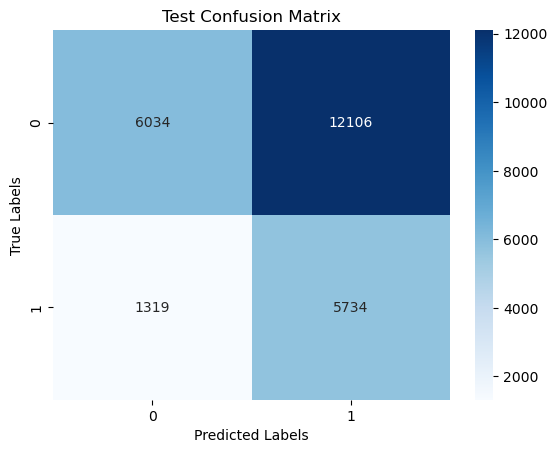

Test Results:
Accuracy: 46.71%
Precision: 32.14%
Recall (TPR): 81.30%
F1 Score: 0.46


In [34]:
# Test Confusion Matrix with Seaborn
y_test_pred = model.predict(test_pool)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(test_conf_matrix, cmap="Blues", annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Calculate test metrics
tn, fp, fn, tp = test_conf_matrix.ravel()
test_accuracy = ((tp + tn) / (tp + tn + fp + fn)) * 100
test_precision = (tp / (tp + fp)) * 100 if (tp + fp) != 0 else 0
test_recall = (tp / (tp + fn)) * 100 if (tp + fn) != 0 else 0
test_fpr = (fp / (fp + tn)) * 100 if (fp + tn) != 0 else 0
test_specificity = (tn / (tn + fp)) * 100 if (tn + fp) != 0 else 0
test_f1_score = (2 * (test_precision * test_recall) / (test_precision + test_recall)) * 0.01 if (test_precision + test_recall) != 0 else 0

# Display test results
print("Test Results:")
print(f"Accuracy: {test_accuracy:.2f}%")
print(f"Precision: {test_precision:.2f}%")
print(f"Recall (TPR): {test_recall:.2f}%")
# print(f"False Positive Rate (FPR): {test_fpr:.2f}%")
# print(f"Specificity (TNR): {test_specificity:.2f}%")
print(f"F1 Score: {test_f1_score:.2f}")

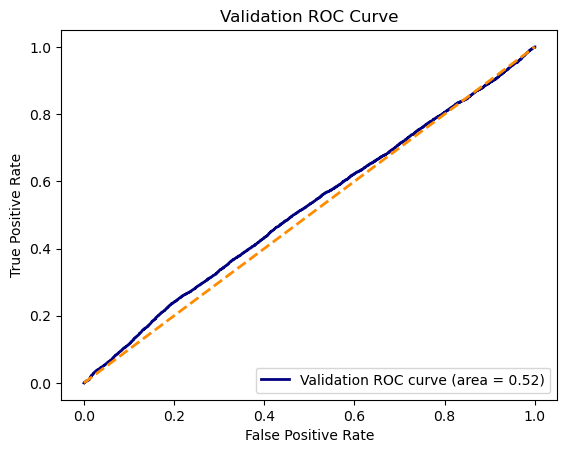

In [35]:
# ROC Curve for validation set
y_val_pred_proba = model.predict_proba(val_pool)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='navy', lw=2, label=f'Validation ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curve')
plt.legend(loc="lower right")
plt.show()

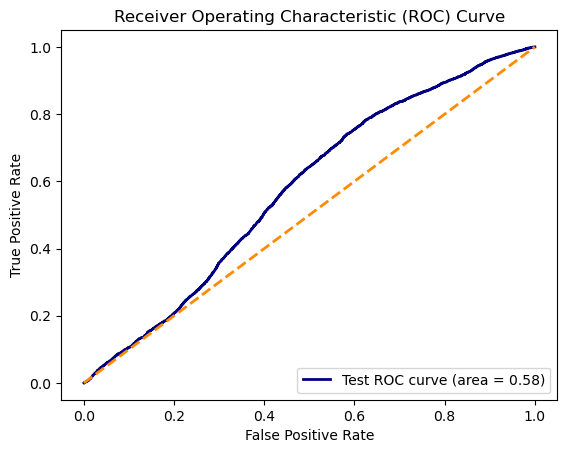

In [36]:
# ROC Curve for test set
y_test_pred_proba = model.predict_proba(test_pool)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='navy', lw=2, label=f'Test ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

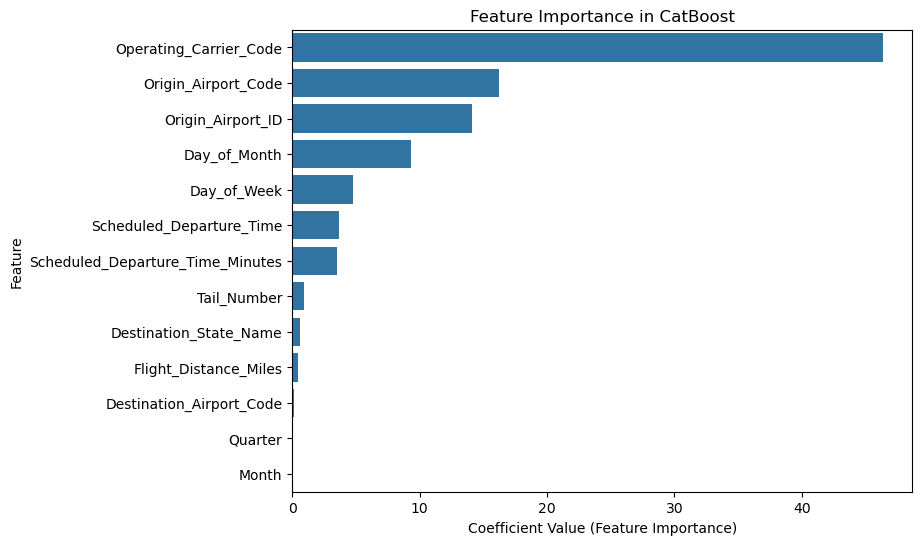

In [37]:
feature_importances = model.get_feature_importance()
feature_names = model.feature_names_

# Create the DataFrame for plotting
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))  # Adjust the size as needed
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, color='#1f77b4')  # Use the specific color
plt.title('Feature Importance in CatBoost')
plt.xlabel('Coefficient Value (Feature Importance)')
plt.ylabel('Feature')

# Save the plot as an image
plt.savefig('feature_importance_plot_catboost.png', dpi=300, bbox_inches='tight')
plt.show()

## Weather Data

In [38]:
weather_columns = [
    "Air_Temperature_Fahrenheit", "Dew_Point_Temperature_Fahrenheit",
    "Relative_Humidity_Percent", "Wind_Direction_Degrees", "Wind_Speed_Knots",
    "Hourly_Precipitation_Inches", "Pressure_Altimeter_Inches",
    "Sea_Level_Pressure_Millibar", "Visibility_Miles", "Sky_Cover_Level_1",
    "Sky_Level_1_Altitude_Feet", "Apparent_Temperature_Fahrenheit"
]


In [39]:
X_train = train_df[weather_columns]
y_train = train_df['Target']
X_val = val_df[weather_columns]
y_val = val_df['Target']
X_test = test_df[weather_columns]
y_test = test_df['Target']

In [40]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158523 entries, 0 to 158522
Data columns (total 12 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   Air_Temperature_Fahrenheit        158523 non-null  float32 
 1   Dew_Point_Temperature_Fahrenheit  158523 non-null  float32 
 2   Relative_Humidity_Percent         158523 non-null  float32 
 3   Wind_Direction_Degrees            158523 non-null  float32 
 4   Wind_Speed_Knots                  158523 non-null  float32 
 5   Hourly_Precipitation_Inches       158523 non-null  float32 
 6   Pressure_Altimeter_Inches         158523 non-null  float32 
 7   Sea_Level_Pressure_Millibar       158523 non-null  float32 
 8   Visibility_Miles                  158523 non-null  float32 
 9   Sky_Cover_Level_1                 158523 non-null  category
 10  Sky_Level_1_Altitude_Feet         158523 non-null  float32 
 11  Apparent_Temperature_Fahrenheit   15852

In [41]:
X_train.head()

,Air_Temperature_Fahrenheit,Dew_Point_Temperature_Fahrenheit,Relative_Humidity_Percent,Wind_Direction_Degrees,Wind_Speed_Knots,Hourly_Precipitation_Inches,Pressure_Altimeter_Inches,Sea_Level_Pressure_Millibar,Visibility_Miles,Sky_Cover_Level_1,Sky_Level_1_Altitude_Feet,Apparent_Temperature_Fahrenheit
0,21.00,15.00,77.449997,60.0,14.0,0.020000,30.0,1025.099976,0.625,VV,1200.0,7.26
1,14.25,9.25,79.980003,350.0,7.0,0.000000,30.0,1025.099976,7.750,OVC,1300.0,3.17
2,21.00,15.00,77.449997,70.0,12.0,0.026667,30.0,1025.699951,0.750,BKN,1300.0,8.03
3,21.00,15.00,77.449997,50.0,11.0,0.027500,30.0,1024.099976,0.750,VV,1400.0,8.45
4,12.50,7.50,79.830002,270.0,8.0,0.001250,30.0,1025.500000,6.000,OVC,1200.0,0.34


In [42]:
for col in X_train.select_dtypes(include=['category']).columns:
    X_train[col] = pd.Categorical(X_train[col])
    X_val[col] = pd.Categorical(X_val[col], categories=X_train[col].cat.categories)
    X_test[col] = pd.Categorical(X_test[col], categories=X_train[col].cat.categories)

# Convert categorical columns to integer codes
X_train = X_train.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
X_val = X_val.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
X_test = X_test.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)

C:\Users\admin\AppData\Local\Temp\ipykernel_13764\3580177747.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = pd.Categorical(X_train[col])
C:\Users\admin\AppData\Local\Temp\ipykernel_13764\3580177747.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[col] = pd.Categorical(X_val[col], categories=X_train[col].cat.categories)
C:\Users\admin\AppData\Local\Temp\ipykernel_13764\3580177747.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [43]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [44]:
model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.05,  
    depth=10,            
    l2_leaf_reg=5,       
    eval_metric='AUC',   
    class_weights=[1, 2],  
    random_seed=42,
    use_best_model=True,
    early_stopping_rounds=100
)


In [45]:
train_pool = Pool(data=X_train_smote, label=y_train_smote)
val_pool = Pool(data=X_val, label=y_val)
test_pool = Pool(data=X_test, label=y_test)

model.fit(train_pool, eval_set=val_pool, verbose=100)


0:	test: 0.6071444	best: 0.6071444 (0)	total: 160ms	remaining: 5m 20s
100:	test: 0.6205955	best: 0.6231471 (36)	total: 16.4s	remaining: 5m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6231471453
bestIteration = 36

Shrink model to first 37 iterations.


In [46]:
y_train_pred = model.predict(train_pool)
train_accuracy = accuracy_score(y_train_smote, y_train_pred)
train_conf_matrix = confusion_matrix(y_train_smote, y_train_pred)

print("Training Results:")
print(f"Accuracy: {train_accuracy:.2f}%")
print("Confusion Matrix:")
print(train_conf_matrix)
print("Classification Report:")
print(classification_report(y_train_smote, y_train_pred))

Training Results:
Accuracy: 0.61%
Confusion Matrix:
[[ 36674  78556]
 [ 10352 104878]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.32      0.45    115230
           1       0.57      0.91      0.70    115230

    accuracy                           0.61    230460
   macro avg       0.68      0.61      0.58    230460
weighted avg       0.68      0.61      0.58    230460



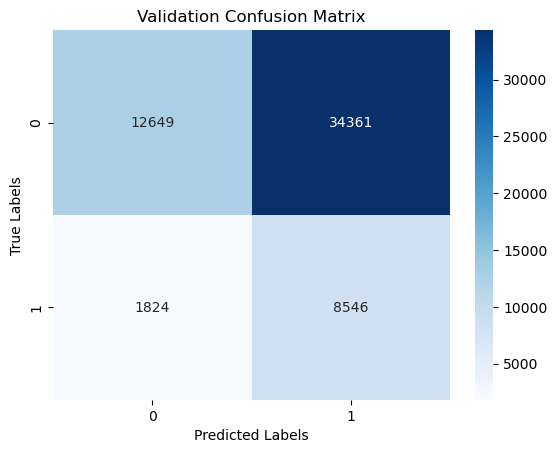

Validation Results:
Accuracy: 36.94%
Precision: 19.92%
Recall (TPR): 82.41%
F1 Score: 0.32


In [47]:
# Validation Confusion Matrix with Seaborn
y_val_pred = model.predict(val_pool)
val_conf_matrix = confusion_matrix(y_val, y_val_pred)
sns.heatmap(val_conf_matrix, cmap="Blues", annot=True, fmt='d')
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Calculate validation metrics
tn, fp, fn, tp = val_conf_matrix.ravel()
val_accuracy = ((tp + tn) / (tp + tn + fp + fn)) * 100
val_precision = (tp / (tp + fp)) * 100 if (tp + fp) != 0 else 0
val_recall = (tp / (tp + fn)) * 100 if (tp + fn) != 0 else 0
val_fpr = (fp / (fp + tn)) * 100 if (fp + tn) != 0 else 0
val_specificity = (tn / (tn + fp)) * 100 if (tn + fp) != 0 else 0
val_f1_score = (2 * (val_precision * val_recall) / (val_precision + val_recall)) * 0.01 if (val_precision + val_recall) != 0 else 0

# Display validation results
print("Validation Results:")
print(f"Accuracy: {val_accuracy:.2f}%")
print(f"Precision: {val_precision:.2f}%")
print(f"Recall (TPR): {val_recall:.2f}%")
# print(f"False Positive Rate (FPR): {val_fpr:.2f}%")
# print(f"Specificity (TNR): {val_specificity:.2f}%")
print(f"F1 Score: {val_f1_score:.2f}")

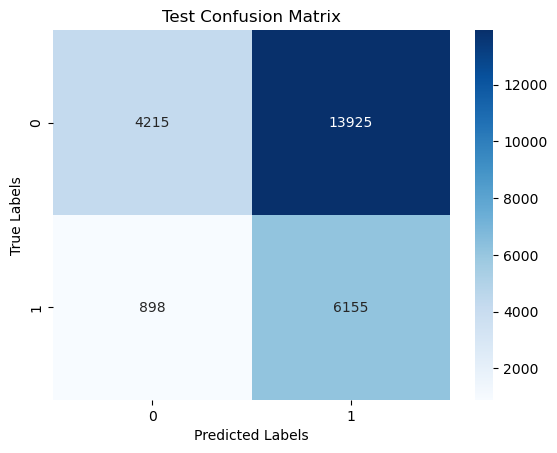

Test Results:
Accuracy: 41.16%
Precision: 30.65%
Recall (TPR): 87.27%
F1 Score: 0.45


In [48]:
y_test_pred = model.predict(test_pool)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(test_conf_matrix, cmap="Blues", annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

tn, fp, fn, tp = test_conf_matrix.ravel()
test_accuracy = ((tp + tn) / (tp + tn + fp + fn)) * 100
test_precision = (tp / (tp + fp)) * 100 if (tp + fp) != 0 else 0
test_recall = (tp / (tp + fn)) * 100 if (tp + fn) != 0 else 0
test_fpr = (fp / (fp + tn)) * 100 if (fp + tn) != 0 else 0
test_specificity = (tn / (tn + fp)) * 100 if (tn + fp) != 0 else 0
test_f1_score = (2 * (test_precision * test_recall) / (test_precision + test_recall)) * 0.01 if (test_precision + test_recall) != 0 else 0

print("Test Results:")
print(f"Accuracy: {test_accuracy:.2f}%")
print(f"Precision: {test_precision:.2f}%")
print(f"Recall (TPR): {test_recall:.2f}%")
# print(f"False Positive Rate (FPR): {test_fpr:.2f}%")
# print(f"Specificity (TNR): {test_specificity:.2f}%")
print(f"F1 Score: {test_f1_score:.2f}")

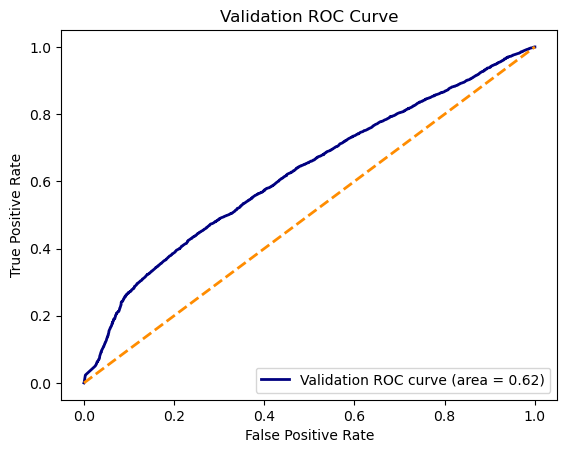

In [49]:
y_val_pred_proba = model.predict_proba(val_pool)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='navy', lw=2, label=f'Validation ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curve')
plt.legend(loc="lower right")
plt.show()

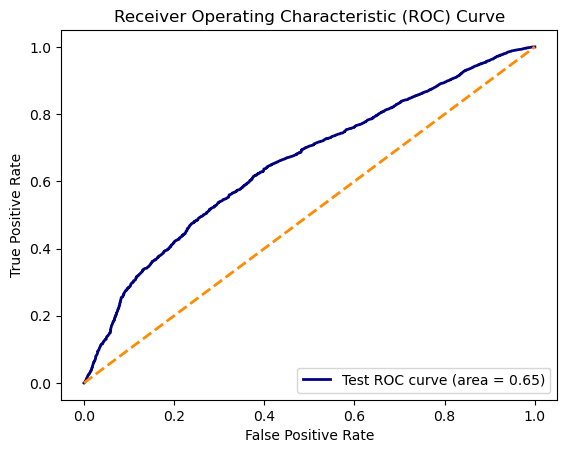

In [50]:
y_test_pred_proba = model.predict_proba(test_pool)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='navy', lw=2, label=f'Test ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

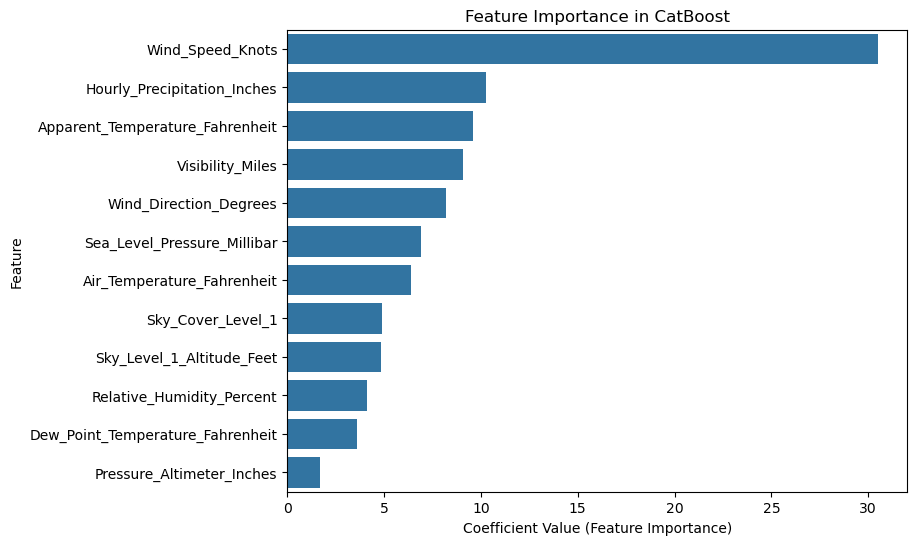

In [51]:
feature_importances = model.get_feature_importance()
feature_names = model.feature_names_

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6)) 
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, color='#1f77b4')  
plt.title('Feature Importance in CatBoost')
plt.xlabel('Coefficient Value (Feature Importance)')
plt.ylabel('Feature')

plt.savefig('feature_importance_plot_catboost.png', dpi=300, bbox_inches='tight')
plt.show()